Here our goal is to reduce the energy as much as possible, at the same time keep track of the cost.

### Imports

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

import matplotlib.pyplot as plt

[Qibo 0.2.9|INFO|2024-06-19 14:50:12]: Using numpy backend on /CPU:0


### Help functions

In [49]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)


def get_gd_evolution_oracle(n_local, params):
    if n_local == 1:
        return MagneticFieldEvolutionOracle(params)
    elif n_local == 2:
        return IsingNNEvolutionOracle(params[:int(len(params)/2)], params[int(len(params)/2):])
    else:
        raise_error(ValueError, "Model not supported, change `n_local` to values in [1, 2]")
     
def gradient_numerical(
    loss_function,
    n_local,
    params: list, 
    loss_0,
    s_0,
    delta: float = 1e-3,
):
    grad = np.zeros(len(params))
    for i in range(len(params)):
        params_new = deepcopy(params)
        params_new[i] += delta
        eo_d = get_gd_evolution_oracle(n_local, params_new)
        # find the increment of a very small step
        grad[i] = (loss_function(s_0, eo_d) - loss_0 ) / delta
        
    # normalize gradient
    grad = grad / max(abs(grad))
    return grad


def adapative_grid_search(loss_function, n_local, params, grad, s_min, s_max, lr_min, lr_max, initial_points, refinement_factor, max_iter, edge_threshold = 0.1):
    best_loss = float('inf')
    best_s = None
    best_lr = None
    last_best_loss = float('inf')
    # given max_iter, find num_refinment from geometric series
    # max_iter > initial_points*(refinement_factor^n-1)/(refinement_factor-1)
    iter_refinement = int(math.log((max_iter * (refinement_factor-1)/initial_points)+1)/math.log(refinement_factor))
    print(iter_refinement)
    for _ in range(iter_refinement):
        num_eval = n_points = int(np.sqrt(initial_points))
        s_values = np.linspace(s_min, s_max, num_eval)
        lr_values = np.linspace(lr_min, lr_max, num_eval)
    
        for s in s_values:
            for lr in lr_values:
                params_eval = deepcopy(params) - grad * lr
                eo_d = get_gd_evolution_oracle(n_local, params_eval)
                # Evaluate the loss function with the current parameters
                loss = loss_function(s, eo_d)
                if loss < best_loss:
                    best_loss = loss
                    best_s = s
                    best_lr = lr
        # condition to stop: worse than last round
        if best_loss > last_best_loss:
            print("break: perform worse than last round")
            break
        else:
            last_best_loss = best_loss
        # adjust range if best params too close to the edge
        s_range = s_max - s_min
        lr_range = lr_max - lr_min
        initial_points = int(initial_points * refinement_factor)
        
        if best_s - s_min < edge_threshold * s_range:
            s_min = max(s_min - s_range / refinement_factor, best_s * edge_threshold)
            s_max = min(s_max, best_s + (best_s - s_min))
            print(f"s {best_s} too small, now range: {s_min,s_max}")
        elif s_max - best_s <edge_threshold * s_range:
            s_max = min(s_max + s_range/refinement_factor, best_s / edge_threshold)
            s_min = max(s_min, best_s - (s_max - best_s))
            print(f"s {best_s} too big, now range: {s_min,s_max}")
        else:
            s_min, s_max = max(s_min, best_s - s_range / refinement_factor), min(s_max, best_s + s_range / refinement_factor)
        if best_lr - lr_min < edge_threshold * lr_range:
            lr_min = max(lr_min - lr_range / refinement_factor, best_lr * edge_threshold)
            lr_max = min(lr_max, best_lr + (best_lr - lr_min))
            print(f"lr {best_lr} too small, now range: {lr_min,lr_max}")
        elif lr_max - best_lr <edge_threshold * lr_range:
            lr_max = lr_max + lr_range/refinement_factor
            lr_min = max(lr_min, best_lr - (lr_max - best_lr))
            print(f"lr {best_lr} too big, now range: {lr_min,lr_max}")
        else:  
            lr_min, lr_max = max(lr_min, best_lr - (lr_max - lr_min) / refinement_factor), min(lr_max, best_lr + (lr_max - lr_min) / refinement_factor)
        
    best_params = params - grad * best_lr
    return best_s, best_lr, best_params, best_loss

## Load VQE

In [42]:
qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q7l/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)

[Qibo 0.2.9|INFO|2024-06-19 16:13:14]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-19 16:13:14]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [43]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)*100}%.\n\
The goal is to reach 1.0% which requires to lower energy to {0.99*target_energy}.")

VQE energy is -14.856898957126571. 
The target energy is -15.276131122065761 which means the difference is 0.41923216493919035.
The relative difference is 2.744360869838478%.
The goal is to reach 1.0% which requires to lower energy to -15.123369810845103.


## 1. Try reduced GCI

In [44]:
# Initialize transpiler code
eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 1, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator)

In [45]:
# Randomized initial b_list
# 1-local magnetic field
b_list = [a+b for a,b in zip(np.random.rand(10)*.2,np.linspace(1,0,10))]
eo_d = MagneticFieldEvolutionOracle(b_list)
# 2-local Ising model
eo_d_Ising = IsingNNEvolutionOracle(b_list,b_list)

([<matplotlib.axis.XTick at 0x17a4301d0>], [Text(0.011, 0, '0.011')])

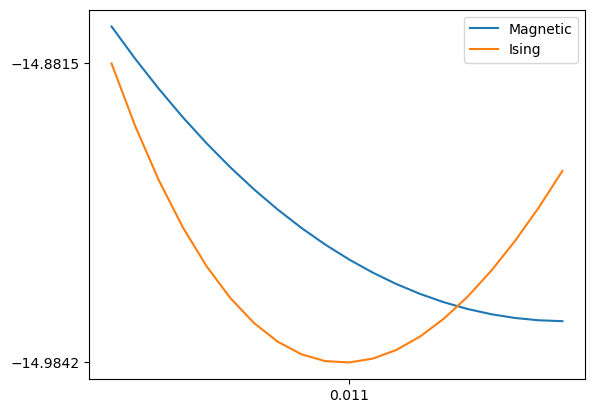

In [46]:
losses_1 = []
losses_2 = []
times = np.linspace(1e-3,2e-2,20)
for s in times:
    losses_1.append(gci.loss(s, eo_d))
    losses_2.append(gci.loss(s, eo_d_Ising))
plt.plot(times,losses_1, label="Magnetic")
plt.plot(times,losses_2, label="Ising")
plt.legend()
plt.yticks([losses_1[0],losses_1[np.argmin(losses_1)]])
plt.xticks([times[np.argmin(losses_1)]])
plt.yticks([losses_2[0],losses_2[np.argmin(losses_2)]])
plt.xticks([times[np.argmin(losses_2)]])

In [47]:
min_loss = min(losses_2)
s_gci_1 = times[np.argmin(losses_2)]
print(f"The minimum energy is achieved by Ising model at {min_loss},\n\
The relative difference is now {abs(ene1-target_energy)/abs(target_energy)*100}%.")

The minimum energy is achieved by Ising model at -14.98419672013946,
The relative difference is now 2.744360869838478%.


To further lower the energy, we try a step of gradient descent.

In [61]:
grad = gradient_numerical(gci.loss, 2,  b_list+b_list, min_loss, s_gci_1 )
print(grad)

[ 0.66820587  0.6007532   0.47269442  0.346592    0.6152511   0.14697815
  0.22332137 -0.04874331 -0.05816658 -0.14937694  1.          0.51475518
  0.6263041   0.45163207  0.44306282  0.17969903  0.05531673 -0.06903722
 -0.15331674 -0.2119381 ]


In [62]:
best_s, best_lr, best_params, best_loss = adapative_grid_search(gci.loss, 2, b_list+b_list, grad, 5e-3, 2e-2, 1e-3, 1, 30, 2, 300)
print(f"The first gradient descent step reduces energy to {best_loss}, a difference of {best_loss - min_loss}.")
print(best_s, best_lr)
best_params_train = best_params
best_loss_train = best_loss
best_s_train = best_s

3
The first gradient descent step reduces energy to -14.989990448343566, a difference of -0.005793728204105619.
0.01625 0.625375


In [63]:
# Training gradient
train_epochs = 10
stuck_counter = 0
last_best_loss = float('inf')
for _ in range(train_epochs):
    grad = gradient_numerical(gci.loss, 2, best_params_train, best_loss_train, best_s_train )
    best_s_train, best_lr_train, best_params_train, best_loss_train = adapative_grid_search(gci.loss, 2, best_params_train, grad, 1e-3, 2e-2, 1e-3, 1e1, 20, 2, 200)
    if best_loss_train < best_loss:
        best_loss = best_loss_train
        best_s = best_s_train
        best_params = best_params_train
        stuck_counter = 0
    if best_loss_train > last_best_loss or best_loss_train - best_loss > 0.001:
        stuck_counter += 1
    last_best_loss = best_loss_train
    # break condition: worsening performance for 3 consecutive runs
    if stuck_counter == 3:
        break
    print(best_loss_train)

3
lr 0.001 too small, now range: (0.0001, 0.0019)
lr 0.0019 too big, now range: (0.001, 0.0028)
lr 0.0028 too big, now range: (0.0018999999999999998, 0.0037)
-14.989962779889336
3
lr 0.001 too small, now range: (0.0001, 0.0019)
lr 0.00172 too big, now range: (0.0009099999999999998, 0.00253)
-14.99001108624754
3
lr 0.001 too small, now range: (0.0001, 0.0019)
lr 0.0001 too small, now range: (1e-05, 0.00019)
lr 0.00019 too big, now range: (9.999999999999999e-05, 0.00028000000000000003)
-14.990016288352297
3
lr 0.001 too small, now range: (0.0001, 0.0019)
lr 0.0001 too small, now range: (1e-05, 0.00019)
lr 0.00019 too big, now range: (9.999999999999999e-05, 0.00028000000000000003)
-14.990021468127214
3
lr 0.001 too small, now range: (0.0001, 0.0019)
lr 0.0001 too small, now range: (1e-05, 0.00019)
lr 0.00019 too big, now range: (9.999999999999999e-05, 0.00028000000000000003)
-14.990026625640574
3
lr 0.001 too small, now range: (0.0001, 0.0019)
lr 0.0001 too small, now range: (1e-05, 0.000

Gradient descent training reached paleau at the second step, we move on to the second step

## 2. 2nd Step

In [14]:
b_list, j_list = best_params
eo_d_Ising = IsingNNEvolutionOracle(b_list,j_list)
print(gci.loss(best_s, eo_d_Ising))
c0 = gci.group_commutator(best_s, eo_d_Ising)["forwards"]
c1 = gci.get_composed_circuit()
v1_circ = c0+c1
hamiltonian.expectation((v1_circ)().state())

-14.986573010822516


-14.986573010822514

In [215]:
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
gci2.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci2.loss()

The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0


-14.99765916110974

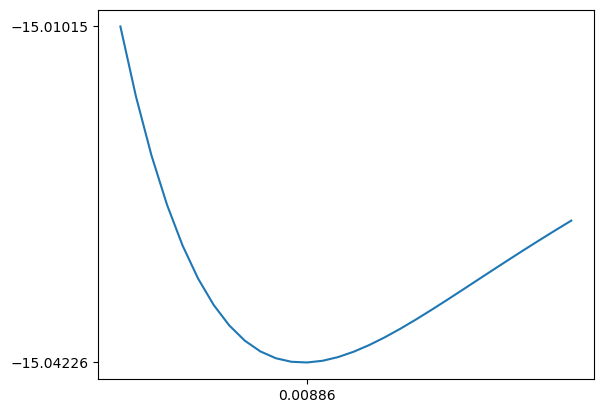

In [217]:
gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(1e-3,2e-2,30)
eo_d_Ising = IsingNNEvolutionOracle(b_list, j_list)
for s in times:
    losses.append(gci2.loss(s, eo_d_Ising))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
initial_loss = min(losses)
s_gci_2nd = times[np.argmin(losses)]

Repeat the steps with gradient descent.

### Gradient descent

In [218]:
grad_b, grad_j = gradient_numerical_Ising(gci2.loss, b_list, j_list, initial_loss, s_gci_2nd )
print(grad_b, grad_j)

[-3.39505855e-04 -5.22973531e-04 -9.09189513e-04 -1.02156535e-03
 -7.21058919e-04 -7.55750396e-05 -2.89893594e-04  8.95563819e-05
  3.66259252e-04  1.83278907e-04] [-6.92320961e-04 -1.11982109e-03 -8.96430697e-04 -1.43416413e-03
 -5.18403807e-04 -3.80469126e-04 -3.26727649e-04 -1.30780945e-04
 -3.04522096e-06 -2.78079581e-04]


In [219]:
best_s, best_lr, best_params, best_loss = adapative_grid_search_Ising(gci2.loss, b_list, j_list, grad_b, grad_j, 5e-3, 2e-2, 1e2, 1e3, 10, 2, 300)
print(f"The first gradient descent step reduces energy to {best_loss}, a difference of {best_loss - initial_loss}.")
print(best_s, best_lr)
b_list_train = best_params[0]
j_list_train = best_params[1]
best_loss_train = best_loss
best_s_train = best_s

The first gradient descent step reduces energy to -15.049103194612776, a difference of -0.00684048287353356.
0.009821428571428571 1000.0


### Gradient training

In [222]:
# Training gradient
train_epochs = 5
stuck_counter = 0
for _ in range(train_epochs):
    grad_b_train, grad_j_train = gradient_numerical_Ising(gci2.loss, b_list_train, j_list_train, best_loss_train, best_s_train )
    best_s_train, best_lr_train, best_params_train, best_loss_train = adapative_grid_search_Ising(gci2.loss, b_list, j_list, grad_b, grad_j, 3e-3, 2e-2, 5e2, 5e3, 20, 2, 100)
    b_list_train = best_params_train[0]
    j_list_train = best_params_train[1]
    if best_loss_train < best_loss:
        best_loss = best_loss_train
        best_s = best_s_train
        best_params = best_params_train
    else:
        stuck_counter += 1
    if stuck_counter == 3:
        break
    print(best_loss)

-15.049103194612776
-15.049103194612776


## 3. 3rd step

In [223]:
b_list, j_list = best_params
eo_d_Ising = IsingNNEvolutionOracle(b_list,j_list)
print(gci2.loss(best_s, eo_d_Ising))
c0 = gci2.group_commutator(best_s, eo_d_Ising)["forwards"]
c1 = gci2.get_composed_circuit()
v2_circ = c0+c1
hamiltonian.expectation((v2_circ)().state()) 

-15.049103194612776


-15.049103194612774

In [224]:
fsoe3  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v2_circ.invert(), after_circuit=v2_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci3  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe3, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)
gci3.print_gate_count_report()
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
gci3.loss()

The boosting circuit used 540 CNOT gates coming from compiled XXZ evolution and 1750 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 54.0 and n_CZ/n_qubits = 175.0


-15.049103194612776

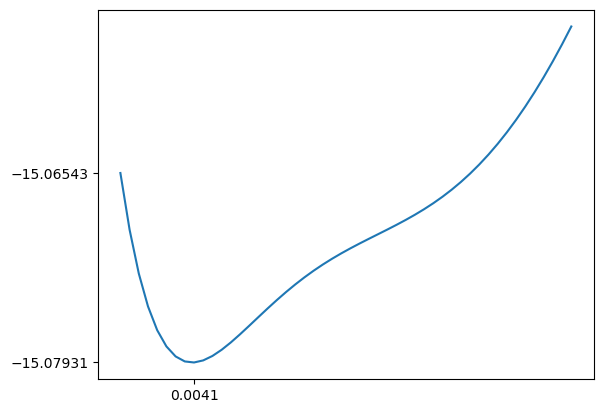

In [225]:
gci3.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
losses = []
times = np.linspace(1e-3,2e-2,50)
eo_d_Ising = IsingNNEvolutionOracle(b_list, j_list)
for s in times:
    losses.append(gci3.loss(s, eo_d_Ising))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])
initial_loss = min(losses)
s_gci_3rd = times[np.argmin(losses)]

### Gradient descent

In [226]:
grad_b, grad_j = gradient_numerical_Ising(gci3.loss, b_list, j_list, initial_loss, s_gci_3rd )
print(grad_b, grad_j)

[-1.89087599e-04 -1.62532137e-04 -6.21149621e-05 -2.68473611e-04
 -2.51489469e-04 -1.30351983e-04 -2.38763109e-04 -1.60984621e-04
 -5.40896306e-05 -1.22584668e-04] [-0.0003177  -0.00019466 -0.00029919 -0.00044205 -0.00027714 -0.00031012
 -0.0003607  -0.00013949 -0.00021503 -0.00025908]


In [231]:
best_s, best_lr, best_params, best_loss = adapative_grid_search_Ising(gci3.loss, b_list, j_list, grad_b, grad_j, 1e-3, 1e-2, 1e2, 2e3, 20, 2, 100)
print(f"The 3rd gradient descent step reduces energy to {best_loss}, a difference of {best_loss - initial_loss}.")
print(best_s, best_lr)
b_list_train = best_params[0]
j_list_train = best_params[1]
best_loss_train = best_loss
best_s_train = best_s

The 3rd gradient descent step reduces energy to -15.082962775970586, a difference of -0.003649529391450912.
0.0055000000000000005 2000.0


### Gradient training

In [229]:
# Training gradient
train_epochs = 1
for _ in range(train_epochs):
    grad_b_train, grad_j_train = gradient_numerical_Ising(gci2.loss, b_list_train, j_list_train, best_loss_train, best_s_train )
    best_s_train, best_lr_train, best_params_train, best_loss_train = adapative_grid_search_Ising(gci2.loss, b_list_train, j_list_train, grad_b_train, grad_j_train, 1e-3, 8e-3, 1e3, 5e4, 15, 2, 50)
    b_list_train = best_params_train[0]
    j_list_train = best_params_train[1]
    if best_loss_train < best_loss:
        best_loss = best_loss_train
        best_s = best_s_train
        best_params = best_params_train
    if best_loss_train > np.round(initial_loss):
        break
    print(best_loss)